In [21]:
import janitor
import matplotlib.pyplot as plt
import missingno
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import sklearn.compose
import sklearn.impute
import sklearn.preprocessing
import statsmodels.api as sm
import statsmodels.datasets
import statsmodels.formula.api as smf
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.mosaicplot import mosaic
import session_info

In [3]:
###add the extension functions notebook for graphs
%run pandas-missing-extension.ipynb

# Data from Statmodels

In [4]:
survival_df = sm.datasets.get_rdataset("flchain", "survival").data
survival_df

,age,sex,sample.yr,kappa,lambda,flc.grp,creatinine,mgus,futime,death,chapter
0,97,F,1997,5.700,4.860,10,1.7,0,85,1,Circulatory
1,92,F,2000,0.870,0.683,1,0.9,0,1281,1,Neoplasms
2,94,F,1997,4.360,3.850,10,1.4,0,69,1,Circulatory
3,92,F,1996,2.420,2.220,9,1.0,0,115,1,Circulatory
4,93,F,1996,1.320,1.690,6,1.1,0,1039,1,Circulatory
...,...,...,...,...,...,...,...,...,...,...,...
7869,52,F,1995,1.210,1.610,6,1.0,0,4997,0,NaN
7870,52,F,1999,0.858,0.581,1,0.8,0,3652,0,NaN
7871,54,F,2002,1.700,1.720,8,NaN,0,2507,0,NaN
7872,53,F,1995,1.710,2.690,9,NaN,0,4982,0,NaN


In [5]:
survival_df.isna()

,age,sex,sample.yr,kappa,lambda,flc.grp,creatinine,mgus,futime,death,chapter
0,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
7869,False,False,False,False,False,False,False,False,False,False,True
7870,False,False,False,False,False,False,False,False,False,False,True
7871,False,False,False,False,False,False,True,False,False,False,True
7872,False,False,False,False,False,False,True,False,False,False,True


## Missing Data Visualisation

<Axes: >

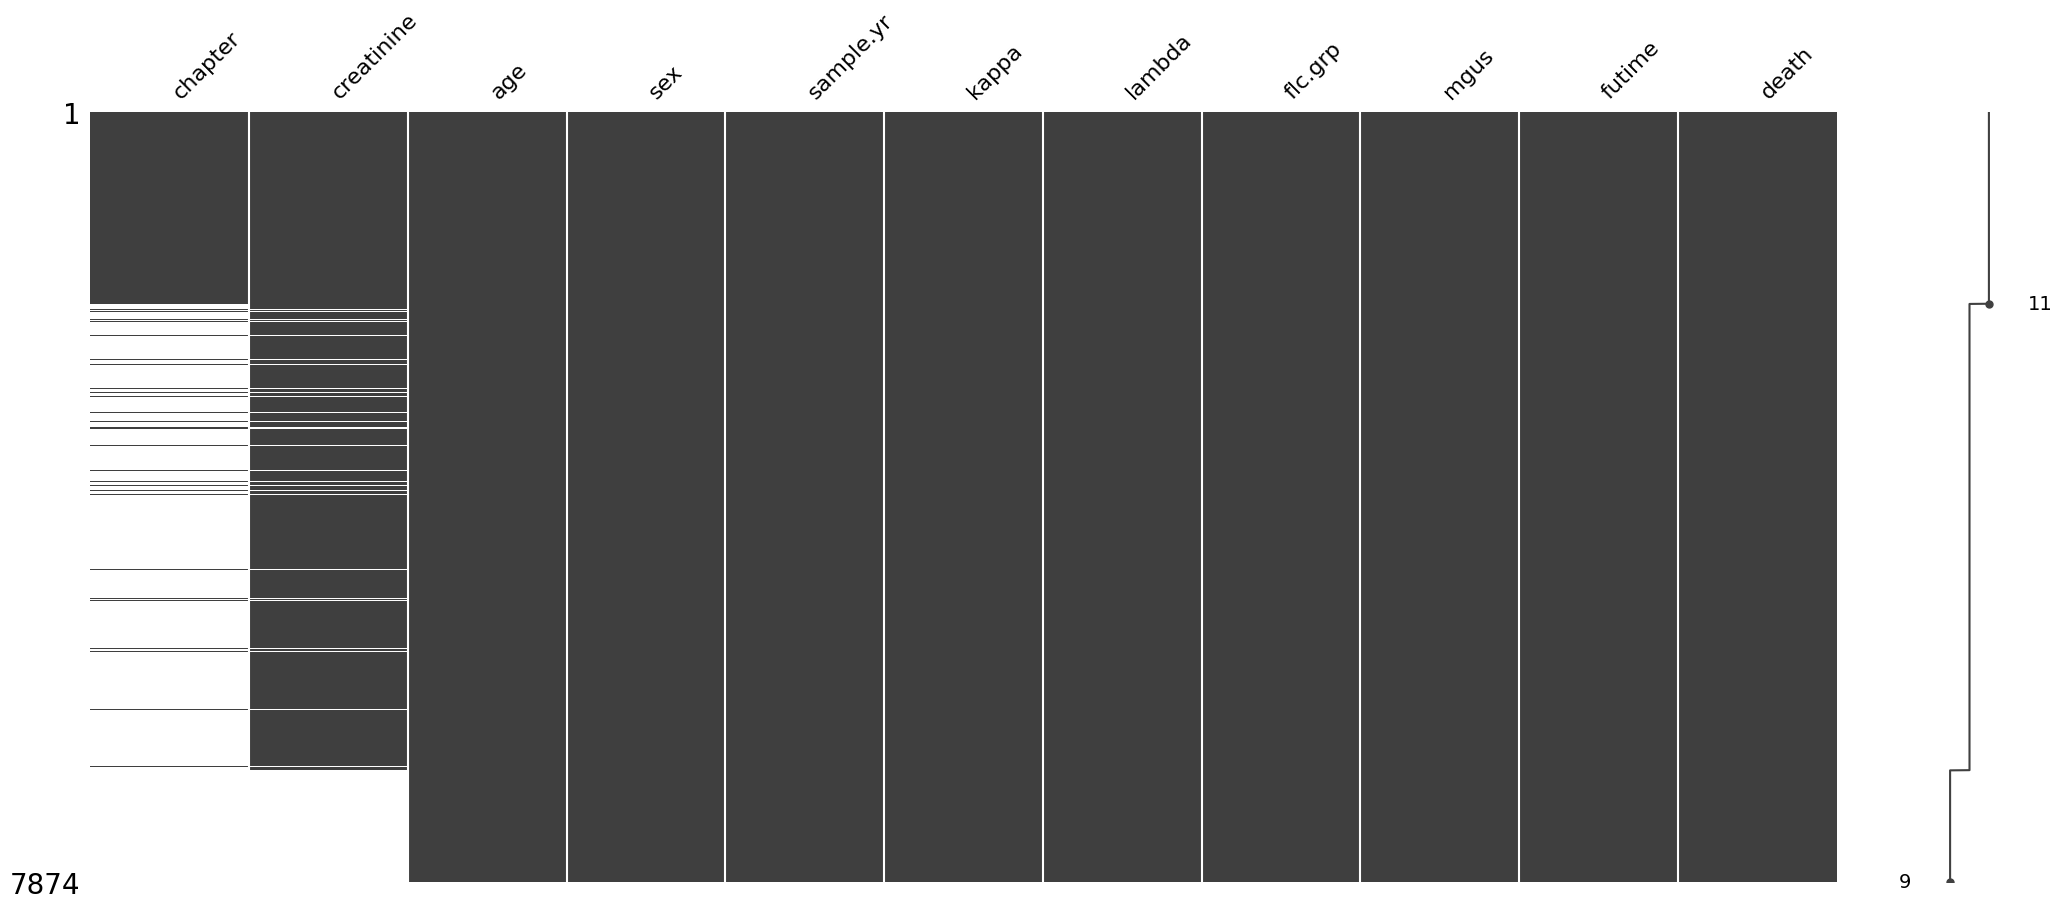

In [5]:
#now we can viasualize the missing Data 
(
    survival_df
    .missing.sort_variables_by_missingness()
    .pipe(missingno.matrix, sort="descending")
) 

{'matrix': <Axes: >,
 'shading': <Axes: >,
 'totals': <Axes: >,
 'intersections': <Axes: ylabel='Intersection size'>}

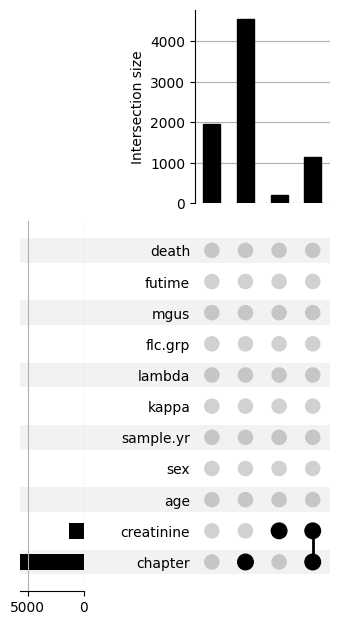

In [6]:
##  we can see that chapter and creatinine variables have a lot of missing Data 
(
    survival_df
    .missing.missing_upsetplot()
    
)

In [7]:
survival_df.chapter.unique()
survival_df["chapter"].value_counts()


Circulatory             745
Neoplasms               567
Respiratory             245
Mental                  144
Nervous                 130
Digestive                66
External Causes          66
Endocrine                48
Genitourinary            42
Ill Defined              38
Infectious               32
Injury and Poisoning     21
Musculoskeletal          14
Blood                     4
Skin                      4
Congenital                3
Name: chapter, dtype: int64

##  Categorical to Numerical for imputation

In [18]:
#extract categorical variables from the DataFrame 
categorical_columns = survival_df.select_dtypes(object).columns
categorical_columns

Index(['sex', 'chapter'], dtype='object')

In [19]:
# we'll use Ordinal Encouder from sklearn 
categorical_transformer = sklearn.compose.make_column_transformer( 
    (sklearn.preprocessing.OrdinalEncoder(), categorical_columns), 
    remainder="passthrough" 
)

categorical_transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('ordinalencoder', OrdinalEncoder(),
                                 Index(['sex', 'chapter'], dtype='object'))])

In [20]:
#transformarion of the Dataset
survival_transformed_df = (
    pd.DataFrame(
        categorical_transformer.fit_transform(survival_df), 
        columns = categorical_transformer.get_feature_names_out(), 
        index = survival_df.index 
    )
    .rename_columns(
        function = lambda x: x.removeprefix("ordinalencoder__")
    )
    .rename_columns(
        function = lambda x: x.removeprefix("onehotencoder__")
    )
    .rename_columns(
        function = lambda x: x.removeprefix("remainder__")
    )
)

survival_transformed_df

,sex,chapter,age,sample.yr,kappa,lambda,flc.grp,creatinine,mgus,futime,death
0,0.0,1.0,97.0,1997.0,5.700,4.860,10.0,1.7,0.0,85.0,1.0
1,0.0,12.0,92.0,2000.0,0.870,0.683,1.0,0.9,0.0,1281.0,1.0
2,0.0,1.0,94.0,1997.0,4.360,3.850,10.0,1.4,0.0,69.0,1.0
3,0.0,1.0,92.0,1996.0,2.420,2.220,9.0,1.0,0.0,115.0,1.0
4,0.0,1.0,93.0,1996.0,1.320,1.690,6.0,1.1,0.0,1039.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
7869,0.0,NaN,52.0,1995.0,1.210,1.610,6.0,1.0,0.0,4997.0,0.0
7870,0.0,NaN,52.0,1999.0,0.858,0.581,1.0,0.8,0.0,3652.0,0.0
7871,0.0,NaN,54.0,2002.0,1.700,1.720,8.0,NaN,0.0,2507.0,0.0
7872,0.0,NaN,53.0,1995.0,1.710,2.690,9.0,NaN,0.0,4982.0,0.0


In [11]:
#We can see the trasformed categories 
(
    categorical_transformer
    .named_transformers_
    .get("ordinalencoder")
    .categories_
)

[array(['F', 'M'], dtype=object),
 array(['Blood', 'Circulatory', 'Congenital', 'Digestive', 'Endocrine',
        'External Causes', 'Genitourinary', 'Ill Defined', 'Infectious',
        'Injury and Poisoning', 'Mental', 'Musculoskeletal', 'Neoplasms',
        'Nervous', 'Respiratory', 'Skin', nan], dtype=object)]

In [12]:

(
    categorical_transformer
    .named_transformers_
    .get("ordinalencoder")
    .inverse_transform(
        X = [[0,12]] ###fisrt row sex and second one chapter 
    )
)


array([['F', 'Neoplasms']], dtype=object)

## Imputation by KNN algorithm

In [13]:
knn_imputer = sklearn.impute.KNNImputer(n_neighbors = 10) 

survival_df_knn = survival_transformed_df.missing.sort_variables_by_missingness(ascending=True).copy(deep=True)

survival_df_knn.iloc[:, :] = knn_imputer.fit_transform(survival_df_knn)

survival_df_knn['chapter'] = survival_df_knn['chapter'].round().astype(int)

survival_df_knn


,sex,age,sample.yr,kappa,lambda,flc.grp,mgus,futime,death,creatinine,chapter
0,0.0,97.0,1997.0,5.700,4.860,10.0,0.0,85.0,1.0,1.70,1
1,0.0,92.0,2000.0,0.870,0.683,1.0,0.0,1281.0,1.0,0.90,12
2,0.0,94.0,1997.0,4.360,3.850,10.0,0.0,69.0,1.0,1.40,1
3,0.0,92.0,1996.0,2.420,2.220,9.0,0.0,115.0,1.0,1.00,1
4,0.0,93.0,1996.0,1.320,1.690,6.0,0.0,1039.0,1.0,1.10,1
...,...,...,...,...,...,...,...,...,...,...,...
7869,0.0,52.0,1995.0,1.210,1.610,6.0,0.0,4997.0,0.0,1.00,9
7870,0.0,52.0,1999.0,0.858,0.581,1.0,0.0,3652.0,0.0,0.80,9
7871,0.0,54.0,2002.0,1.700,1.720,8.0,0.0,2507.0,0.0,1.04,5
7872,0.0,53.0,1995.0,1.710,2.690,9.0,0.0,4982.0,0.0,0.99,9


<Axes: xlabel='chapter', ylabel='creatinine'>

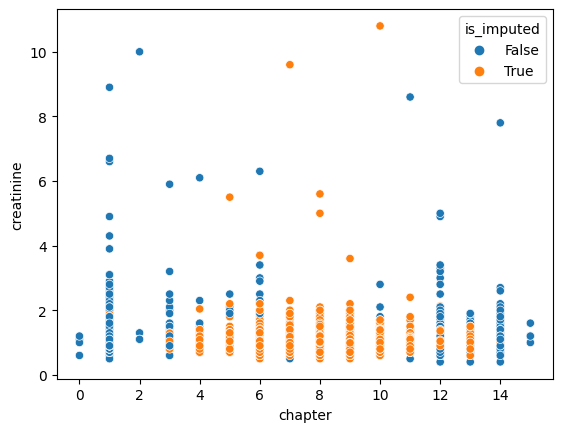

In [14]:
#dsitribution of the imputed Data (Orange points) using shadow matrix 
(
    pd.concat(
        [
            survival_df_knn,
            survival_df.missing.create_shadow_matrix(True, False, suffix="_imp", only_missing=False) 
        ],
        axis=1
    )
    .missing.scatter_imputation_plot(x="chapter", y="creatinine") 

)

## Multiple Imputation by Chained Equations

In [15]:
mice_imputer = sklearn.impute.IterativeImputer(estimator=BayesianRidge(), initial_strategy="mean", imputation_order="ascending")###

survival_mice_df = survival_transformed_df.copy(deep = True)

survival_mice_df.iloc[:, :] = mice_imputer.fit_transform(survival_mice_df)

survival_mice_df['chapter'] = survival_mice_df['chapter'].round().astype(int)



In [114]:
survival_mice_df

,sex,chapter,age,sample.yr,kappa,lambda,flc.grp,creatinine,mgus,futime,death
0,0.0,1,97.0,1997.0,5.700,4.860,10.0,1.700000,0.0,85.0,1.0
1,0.0,12,92.0,2000.0,0.870,0.683,1.0,0.900000,0.0,1281.0,1.0
2,0.0,1,94.0,1997.0,4.360,3.850,10.0,1.400000,0.0,69.0,1.0
3,0.0,1,92.0,1996.0,2.420,2.220,9.0,1.000000,0.0,115.0,1.0
4,0.0,1,93.0,1996.0,1.320,1.690,6.0,1.100000,0.0,1039.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
7869,0.0,9,52.0,1995.0,1.210,1.610,6.0,1.000000,0.0,4997.0,0.0
7870,0.0,10,52.0,1999.0,0.858,0.581,1.0,0.800000,0.0,3652.0,0.0
7871,0.0,10,54.0,2002.0,1.700,1.720,8.0,0.959409,0.0,2507.0,0.0
7872,0.0,9,53.0,1995.0,1.710,2.690,9.0,0.972599,0.0,4982.0,0.0


In [16]:
survival_mice_lol = pd.concat(
    [
        survival_mice_df,
        survival_df.missing.create_shadow_matrix(True, False, suffix="_imp", only_missing=False)
    ],
    axis = 1
)



<Axes: xlabel='chapter', ylabel='creatinine'>

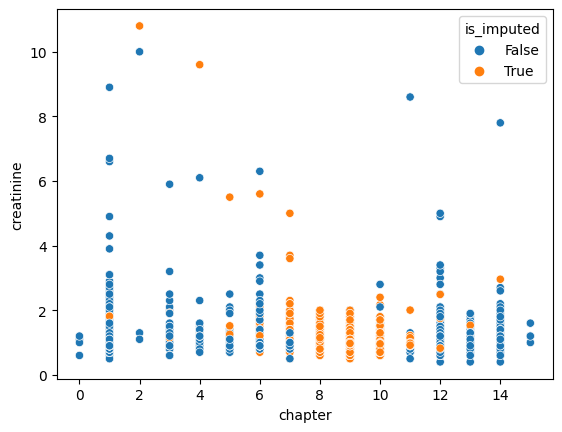

In [118]:
#dsitribution of the imputed Data (Orange points)
survival_mice_lol.missing.scatter_imputation_plot(x="chapter", y="creatinine") 

##  Inverse Transformation

In [17]:
survival_imputated_df_MIC = survival_mice_lol.copy(deep=True) 

survival_imputated_df_MIC[categorical_columns] = (  
    categorical_transformer 
    .named_transformers_ 
    .ordinalencoder
    .inverse_transform(  
        X = survival_mice_df[categorical_columns]
    )
)

survival_imputated_df_MIC

,sex,chapter,age,sample.yr,kappa,lambda,flc.grp,creatinine,mgus,futime,...,sex_imp,sample.yr_imp,kappa_imp,lambda_imp,flc.grp_imp,creatinine_imp,mgus_imp,futime_imp,death_imp,chapter_imp
0,F,Circulatory,97.0,1997.0,5.700,4.860,10.0,1.700000,0.0,85.0,...,False,False,False,False,False,False,False,False,False,False
1,F,Neoplasms,92.0,2000.0,0.870,0.683,1.0,0.900000,0.0,1281.0,...,False,False,False,False,False,False,False,False,False,False
2,F,Circulatory,94.0,1997.0,4.360,3.850,10.0,1.400000,0.0,69.0,...,False,False,False,False,False,False,False,False,False,False
3,F,Circulatory,92.0,1996.0,2.420,2.220,9.0,1.000000,0.0,115.0,...,False,False,False,False,False,False,False,False,False,False
4,F,Circulatory,93.0,1996.0,1.320,1.690,6.0,1.100000,0.0,1039.0,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7869,F,Injury and Poisoning,52.0,1995.0,1.210,1.610,6.0,1.000000,0.0,4997.0,...,False,False,False,False,False,False,False,False,False,True
7870,F,Mental,52.0,1999.0,0.858,0.581,1.0,0.800000,0.0,3652.0,...,False,False,False,False,False,False,False,False,False,True
7871,F,Mental,54.0,2002.0,1.700,1.720,8.0,0.959409,0.0,2507.0,...,False,False,False,False,False,True,False,False,False,True
7872,F,Injury and Poisoning,53.0,1995.0,1.710,2.690,9.0,0.972599,0.0,4982.0,...,False,False,False,False,False,True,False,False,False,True


In [124]:
survival_imputated_df_KNN = survival_df_knn.copy(deep=True) 

survival_imputated_df_KNN[categorical_columns] = (  
    categorical_transformer 
    .named_transformers_ 
    .ordinalencoder
    .inverse_transform(  
        X = survival_df_knn[categorical_columns]
    )
)

survival_imputated_df_KNN

,sex,age,sample.yr,kappa,lambda,flc.grp,mgus,futime,death,creatinine,chapter
0,F,97.0,1997.0,5.700,4.860,10.0,0.0,85.0,1.0,1.70,Circulatory
1,F,92.0,2000.0,0.870,0.683,1.0,0.0,1281.0,1.0,0.90,Neoplasms
2,F,94.0,1997.0,4.360,3.850,10.0,0.0,69.0,1.0,1.40,Circulatory
3,F,92.0,1996.0,2.420,2.220,9.0,0.0,115.0,1.0,1.00,Circulatory
4,F,93.0,1996.0,1.320,1.690,6.0,0.0,1039.0,1.0,1.10,Circulatory
...,...,...,...,...,...,...,...,...,...,...,...
7869,F,52.0,1995.0,1.210,1.610,6.0,0.0,4997.0,0.0,1.00,Injury and Poisoning
7870,F,52.0,1999.0,0.858,0.581,1.0,0.0,3652.0,0.0,0.80,Injury and Poisoning
7871,F,54.0,2002.0,1.700,1.720,8.0,0.0,2507.0,0.0,1.04,External Causes
7872,F,53.0,1995.0,1.710,2.690,9.0,0.0,4982.0,0.0,0.99,Injury and Poisoning


Now we have two DataFrames with no missing values using to diffrent approaches
1. survival_imputated_df_KNN
2. survival_imputated_df_MIC

In [23]:
session_info.show()